## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna

In [2]:
# Set display options

pd.set_option("display.max_columns", None)

In [3]:
sns.set_style("whitegrid")

## 1. Load and Explore Data

In [4]:
df = pd.read_csv('german_credit_data.csv')
df.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Risk  
0           1169         6             radio/TV  good  
1           5951        48             radio/TV   bad  
2           2096        12            education  good  
3           7882        42  furniture/equipment  good  
4           4870        24                  car   bad

In [5]:
# Summary statistics

df['Age'].describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Age, dtype: float64

In [6]:
df.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [7]:
df.shape

(1000, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [9]:
df.describe(include = 'all').T

count unique     top freq      mean          std    min  \
Unnamed: 0        1000.0    NaN     NaN  NaN     499.5   288.819436    0.0   
Age               1000.0    NaN     NaN  NaN    35.546    11.375469   19.0   
Sex                 1000      2    male  690       NaN          NaN    NaN   
Job               1000.0    NaN     NaN  NaN     1.904     0.653614    0.0   
Housing             1000      3     own  713       NaN          NaN    NaN   
Saving accounts      817      4  little  603       NaN          NaN    NaN   
Checking account     606      3  little  274       NaN          NaN    NaN   
Credit amount     1000.0    NaN     NaN  NaN  3271.258  2822.736876  250.0   
Duration          1000.0    NaN     NaN  NaN    20.903    12.058814    4.0   
Purpose             1000      8     car  337       NaN          NaN    NaN   
Risk                1000      2    good  700       NaN          NaN    NaN   

                     25%     50%      75%      max  
Unnamed: 0        249.75   499.5   749.25    999.0  
Age                 27.0    33.0     42.0     75.0  
Sex                  NaN     NaN      NaN      NaN  
Job                  2.0     2.0      2.0      3.0  
Housing              NaN     NaN      NaN      NaN  
Saving accounts      NaN     NaN      NaN      NaN  
Checking account     NaN     NaN      NaN      NaN  
Credit amount     1365.5  2319.5  3972.25  18424.0  
Duration            12.0    18.0     24.0     72.0  
Purpose              NaN     NaN      NaN      NaN  
Risk                 NaN     NaN      NaN      NaN

In [10]:
# Check unique values for categorical column

df['Job'].unique()

array([2, 1, 3, 0], dtype=int64)

0 - Less important job

3 - Most important job

In [11]:
df.duplicated().sum()

0

In [12]:
# Drop missing values and unnecessary columns

df = df.dropna().reset_index(drop = True)
df

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0             1   22  female    2     own          little         moderate   
1             3   45    male    2    free          little           little   
2             4   53    male    2    free          little           little   
3             7   35    male    3    rent          little         moderate   
4             9   28    male    3     own          little         moderate   
..          ...  ...     ...  ...     ...             ...              ...   
517         989   48    male    1     own          little         moderate   
518         993   30    male    3     own          little           little   
519         996   40    male    3     own          little           little   
520         998   23    male    2    free          little           little   
521         999   27    male    2     own        moderate         moderate   

     Credit amount  Duration              Purpose  Risk  
0             5951        48             radio/TV   bad  
1             7882        42  furniture/equipment  good  
2             4870        24                  car   bad  
3             6948        36                  car  good  
4             5234        30                  car   bad  
..             ...       ...                  ...   ...  
517           1743        24             radio/TV  good  
518           3959        36  furniture/equipment  good  
519           3857        30                  car  good  
520           1845        45             radio/TV   bad  
521           4576        45                  car  good  

[522 rows x 11 columns]

In [13]:
df.drop(columns = 'Unnamed: 0', inplace = True)


In [14]:
df.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   22  female    2     own          little         moderate           5951   
1   45    male    2    free          little           little           7882   
2   53    male    2    free          little           little           4870   
3   35    male    3    rent          little         moderate           6948   
4   28    male    3     own          little         moderate           5234   

   Duration              Purpose  Risk  
0        48             radio/TV   bad  
1        42  furniture/equipment  good  
2        24                  car   bad  
3        36                  car  good  
4        30                  car   bad

In [15]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

## 2. Exploratory Data Analysis (EDA)

### # 2.1 Distribution of numerical features

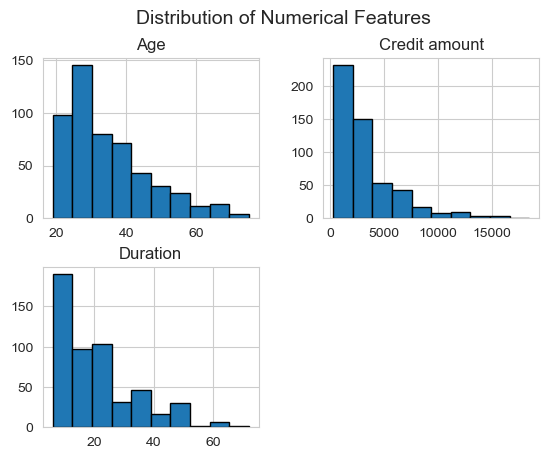

In [16]:
df[["Age", "Credit amount", "Duration"]].hist(bins = 10, edgecolor = 'black')
plt.suptitle('Distribution of Numerical Features', fontsize = 14)
plt.show()

### 2.2 Boxplots for numerical features

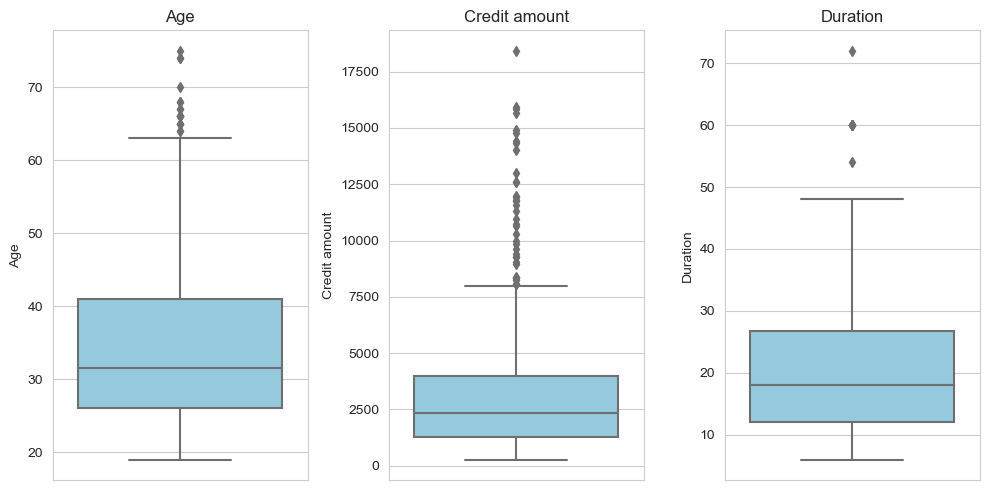

In [17]:
plt.figure(figsize = (10, 5))

for i, col in enumerate(["Age", "Credit amount", "Duration"]):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y = df[col], color = 'skyblue')
    plt.title(col)
    
plt.tight_layout()
plt.show()

In [18]:
df.query("Duration >= 60")

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
18    63    male    2     own          little           little           6836   
176   24  female    3     own        moderate         moderate           7408   
199   60  female    3    free        moderate         moderate          14782   
358   24    male    2     own        moderate         moderate           5595   
378   27    male    3     own          little         moderate          14027   
489   42    male    2    free          little         moderate           6288   
507   36    male    2    rent          little           little           7297   

     Duration          Purpose Risk  
18         60         business  bad  
176        60              car  bad  
199        60  vacation/others  bad  
358        72         radio/TV  bad  
378        60              car  bad  
489        60        education  bad  
507        60         business  bad

### 2.3 Countplots for categorical variables

In [19]:
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

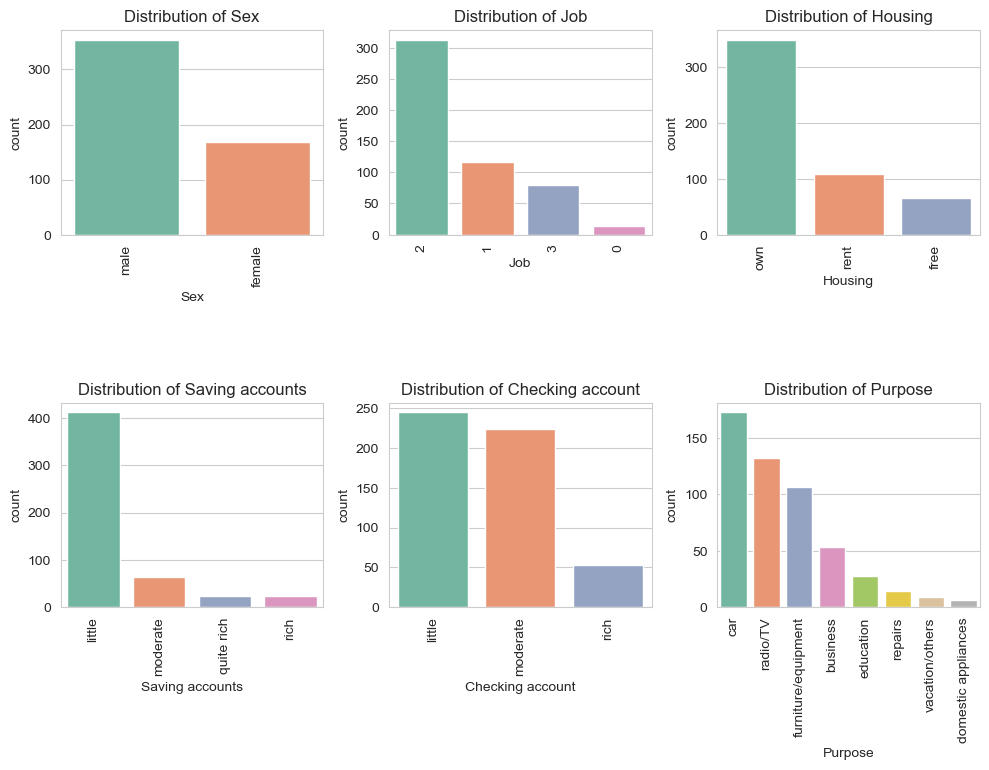

In [22]:
plt.figure(figsize = (10, 10))
for i,col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data = df, x = col, palette = 'Set2', order = df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation = 90)
    
plt.tight_layout()
plt.show()

### 2.4 Correlation heatmap

In [23]:
corr = df[['Age', 'Job', 'Credit amount', 'Duration']].corr()

In [24]:
corr

Age       Job  Credit amount  Duration
Age            1.000000  0.039771       0.082014  0.001549
Job            0.039771  1.000000       0.334721  0.200794
Credit amount  0.082014  0.334721       1.000000  0.613298
Duration       0.001549  0.200794       0.613298  1.000000

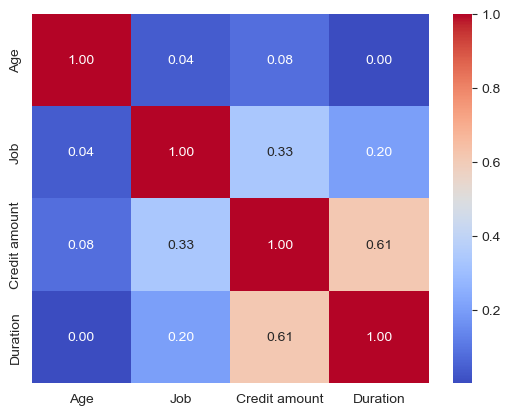

In [25]:
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.show()

### 2.5 Grouped analysis

In [26]:
df.groupby('Job')['Credit amount'].mean()

Job
0    1767.857143
1    2250.715517
2    3129.130990
3    5648.784810
Name: Credit amount, dtype: float64

In [27]:
df.groupby('Sex')['Credit amount'].mean()

Sex
female    2937.202381
male      3440.833333
Name: Credit amount, dtype: float64

In [28]:
pd.pivot_table(df, values = 'Credit amount', index = 'Housing', columns = 'Purpose')

Purpose     business          car  domestic appliances    education  \
Housing                                                               
free     4705.000000  5180.314286                  NaN  5314.250000   
own      3725.973684  3120.485437               1333.5  2625.076923   
rent     6180.833333  3398.285714                  NaN  2627.857143   

Purpose  furniture/equipment     radio/TV  repairs  vacation/others  
Housing                                                              
free             4419.444444  2097.000000   1190.0      7842.666667  
own              3031.100000  2307.613861   2993.5     10321.833333  
rent             2890.285714  2138.000000   2384.0              NaN

### 2.6 Visual relationships

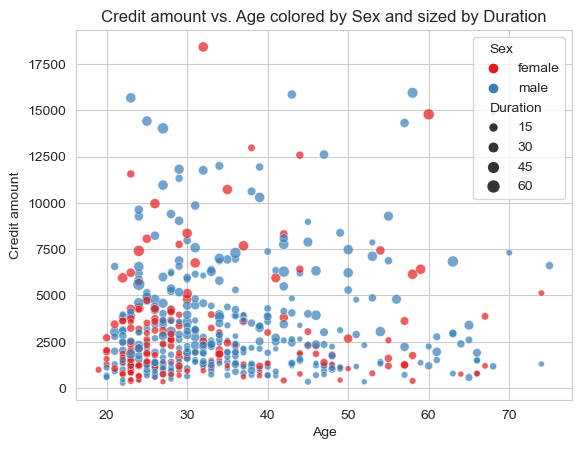

In [29]:
sns.scatterplot(data = df, x = 'Age', y = 'Credit amount', hue = 'Sex', size = 'Duration', alpha = 0.7, palette = 'Set1')
plt.title('Credit amount vs. Age colored by Sex and sized by Duration')
plt.show()

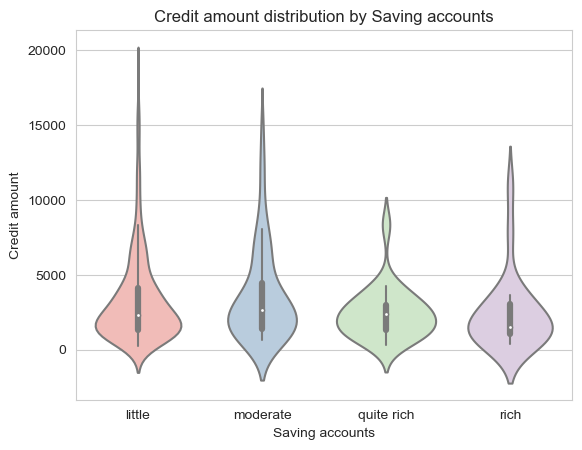

In [32]:
sns.violinplot(data = df, x = 'Saving accounts', y = 'Credit amount', palette = 'Pastel1')
plt.title('Credit amount distribution by Saving accounts')
plt.show()

### 2.7 Risk distribution

In [33]:
df['Risk'].value_counts(normalize = True) * 100

good    55.747126
bad     44.252874
Name: Risk, dtype: float64

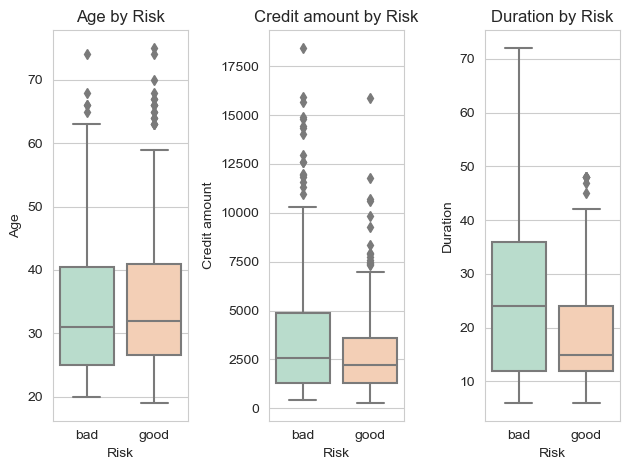

In [34]:
for i, col in enumerate(['Age', 'Credit amount', 'Duration']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data = df, x = "Risk", y = col, palette = "Pastel2")
    plt.title(f'{col} by Risk')
    
plt.tight_layout()
plt.show()

In [35]:
df.groupby('Risk')[['Age', 'Credit amount', 'Duration']].mean()

Age  Credit amount   Duration
Risk                                     
bad   34.147186    3881.090909  25.445887
good  35.477663    2800.594502  18.079038

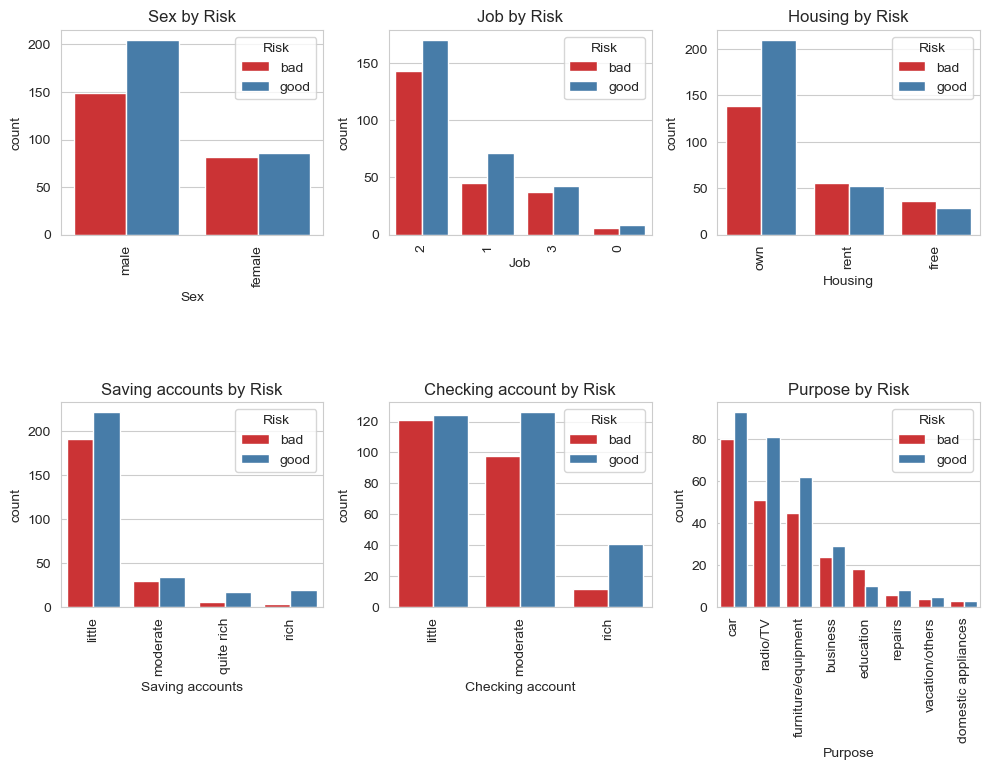

In [40]:
plt.figure(figsize = (10, 10))

for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(data = df, x = col, hue = 'Risk', palette = "Set1", order = df[col].value_counts().index)
    plt.title(f'{col} by Risk')
    plt.xticks(rotation = 90)
    
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [41]:
# Define features and target

features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']
target = 'Risk'

In [42]:
df_model = df[features + [target]].copy()

In [43]:
df_model.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   22  female    2     own          little         moderate           5951   
1   45    male    2    free          little           little           7882   
2   53    male    2    free          little           little           4870   
3   35    male    3    rent          little         moderate           6948   
4   28    male    3     own          little         moderate           5234   

   Duration  Risk  
0        48   bad  
1        42  good  
2        24   bad  
3        36  good  
4        30   bad

In [45]:
# Encode categorical variables

cat_cols = df_model.select_dtypes(include = 'object').columns.drop('Risk')

In [46]:
le_dict = {}

In [47]:
cat_cols

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account'], dtype='object')

In [48]:
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_dict[col] = le
    joblib.dump(le, f'{col}_encoder.pkl')

In [49]:
# Encode target

le_target = LabelEncoder()

In [51]:
df_model[target] = le_target.fit_transform(df_model[target])

In [52]:
df_model[target].value_counts()

1    291
0    231
Name: Risk, dtype: int64

In [53]:
joblib.dump(le_target, 'target_encoder.pkl')

['target_encoder.pkl']

In [54]:
df_model.head()

Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0   22    0    2        1                0                 1           5951   
1   45    1    2        0                0                 0           7882   
2   53    1    2        0                0                 0           4870   
3   35    1    3        2                0                 1           6948   
4   28    1    3        1                0                 1           5234   

   Duration  Risk  
0        48     0  
1        42     1  
2        24     0  
3        36     1  
4        30     0

## 4. Train-Test Split and Resampling

In [56]:
X = df_model.drop(target, axis = 1)
y = df_model[target]

In [57]:
X

Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0     22    0    2        1                0                 1           5951   
1     45    1    2        0                0                 0           7882   
2     53    1    2        0                0                 0           4870   
3     35    1    3        2                0                 1           6948   
4     28    1    3        1                0                 1           5234   
..   ...  ...  ...      ...              ...               ...            ...   
517   48    1    1        1                0                 1           1743   
518   30    1    3        1                0                 0           3959   
519   40    1    3        1                0                 0           3857   
520   23    1    2        0                0                 0           1845   
521   27    1    2        1                1                 1           4576   

     Duration  
0          48  
1          42  
2          24  
3          36  
4          30  
..        ...  
517        24  
518        36  
519        30  
520        45  
521        45  

[522 rows x 8 columns]

In [58]:
y

0      0
1      1
2      0
3      1
4      0
      ..
517    1
518    1
519    1
520    0
521    1
Name: Risk, Length: 522, dtype: int32

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

In [86]:
# Handle class imbalance using SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [185 232]
After SMOTE: [232 232]


In [60]:
X_train.shape

(417, 8)

In [61]:
X_test.shape

(105, 8)

## 5. Baseline Models (Decision Tree, Random Forest, Extra Trees, XGBoost)

In [63]:
def train_model(model, param_grid, X_train, y_train, X_test, y_test):
    """
    Trains a model using GridSearchCV and returns best model and accuracy.
    """
    grid = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return best_model, acc, grid.best_params_

### 5.1 Decision Tree Classifier

In [67]:
dt = DecisionTreeClassifier(random_state=1, class_weight='balanced')
dt_param_grid = {'max_depth' : [3, 5, 7, 10, None],
                   'min_samples_split' : [2, 5, 10],
                   'min_samples_leaf' : [1, 2, 4]}

In [68]:
best_dt, acc_dt, params_dt = train_model(dt, dt_param_grid, X_train, y_train, X_test, y_test)

In [69]:
print('Decision Tree Accuracy: ', acc_dt)

Decision Tree Accuracy:  0.580952380952381


In [70]:
print('Best Parameters: ', params_dt)

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


### 5.2 Random Forest Classifier

In [72]:
rf = RandomForestClassifier(random_state=1, class_weight='balanced', n_jobs = -1)
rf_param_grid = {'n_estimators' : [100, 200],
                 'max_depth' : [5, 7, 10, None],
                 'min_samples_split' : [2, 5, 10],
                 'min_samples_leaf' : [1, 2, 4]}

In [73]:
best_rf, acc_rf, params_rf = train_model(rf, rf_param_grid, X_train, y_train, X_test, y_test)

In [74]:
print('Random Forest Accuracy: ', acc_rf)


Random Forest Accuracy:  0.6190476190476191


In [75]:
print('Best Parameters: ', params_rf)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


### 5.3 Extra Trees Classifier

In [76]:
et = ExtraTreesClassifier(random_state=1, class_weight='balanced', n_jobs = -1)
et_param_grid = {'n_estimators' : [100, 200],
                 'max_depth' : [5, 7, 10, None],
                 'min_samples_split' : [2, 5, 10],
                 'min_samples_leaf' : [1, 2, 4]}

In [77]:
best_et, acc_et, params_et = train_model(et, et_param_grid, X_train, y_train, X_test, y_test)

In [78]:
print('Extra Trees Accuracy: ', acc_et)

Extra Trees Accuracy:  0.6476190476190476


In [79]:
print('Best Parameters: ', params_et)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


### 5.4 XGBoost Classifier

In [80]:
xgb = XGBClassifier(random_state=1, scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(), use_label_encoder = False, eval_metric = 'logloss')
xgb_param_grid = {'n_estimators' : [100, 200],
                 'max_depth' : [3, 5, 7],
                 'learning_rate' : [0.01, 0.1, 0.2],
                 'sub_sample' : [0.7, 1],
                 'colsample_bytree' : [0.7, 1]}

In [81]:
best_xgb, acc_xgb, params_xgb = train_model(xgb, xgb_param_grid, X_train, y_train, X_test, y_test)

C:\Users\RATHOD\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [12:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


In [83]:
print('XGBoost Accuracy: ', acc_xgb)

XGBoost Accuracy:  0.6761904761904762


In [84]:
print('Best Parameters: ', params_xgb)

Best Parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'sub_sample': 0.7}


In [87]:
models = {
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(
        random_state=42, eval_metric="logloss", use_label_encoder=False
    )
}

In [88]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.2f})")
    
    return roc_auc_score(y_test, y_prob)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 232, number of negative: 232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 464, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

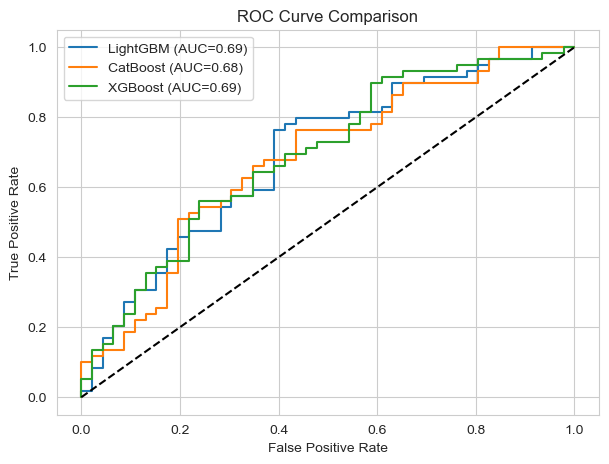

In [89]:
plt.figure(figsize=(7, 5))
for name, model in models.items():
    evaluate_model(name, model, X_train_res, y_train_res, X_test, y_test)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

## 6. Hyperparameter Tuning with Optuna

In [90]:
def objective_lgbm(trial):
    
    """Objective function for Optuna tuning of LGBMClassifier"""

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
    }
    model = LGBMClassifier(random_state=42, **params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in cv.split(X_train_res, y_train_res):
        X_tr, X_val = X_train_res.iloc[train_idx], X_train_res.iloc[valid_idx]
        y_tr, y_val = y_train_res.iloc[train_idx], y_train_res.iloc[valid_idx]
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_prob))
    return np.mean(scores)

In [91]:
def objective_catboost(trial):
    
    """Objective function for Optuna tuning of CatBoostClassifier"""
    
    params = {
        "iterations": trial.suggest_int("iterations", 200, 600),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
    }
    model = CatBoostClassifier(random_state=42, verbose=0, **params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in cv.split(X_train_res, y_train_res):
        X_tr, X_val = X_train_res.iloc[train_idx], X_train_res.iloc[valid_idx]
        y_tr, y_val = y_train_res.iloc[train_idx], y_train_res.iloc[valid_idx]
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_prob))
    return np.mean(scores)


In [92]:
def objective_xgb(trial):
    
    """Objective function for Optuna tuning of XGBClassifier"""
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
    }
    model = XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False, **params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in cv.split(X_train_res, y_train_res):
        X_tr, X_val = X_train_res.iloc[train_idx], X_train_res.iloc[valid_idx]
        y_tr, y_val = y_train_res.iloc[train_idx], y_train_res.iloc[valid_idx]
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_prob))
    return np.mean(scores)

### Run Optuna studies

In [97]:
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2025-09-25 12:38:09,449] A new study created in memory with name: no-name-a21b5025-cde4-47b4-9d75-b9c1f980c894
[I 2025-09-25 12:38:09,965] Trial 0 finished with value: 0.7464545710493505 and parameters: {'n_estimators': 140, 'max_depth': 6, 'learning_rate': 0.06533015218981816, 'num_leaves': 63, 'subsample': 0.6745209228961733, 'colsample_bytree': 0.8963823677812639}. Best is trial 0 with value: 0.7464545710493505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 185, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498652 -> initscore=-0.005391
[LightGBM] [Info] Start training from score -0.005391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-09-25 12:38:10,432] Trial 1 finished with value: 0.7492901098017135 and parameters: {'n_estimators': 472, 'max_depth': 7, 'learning_rate': 0.03641031410726848, 'num_leaves': 68, 'subsample': 0.9471996852278548, 'colsample_bytree': 0.7261632655255497}. Best is trial 1 with value: 0.7492901098017135.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:10,836] Trial 2 finished with value: 0.742653742508949 and parameters: {'n_estimators': 438, 'max_depth': 7, 'learning_rate': 0.08168560392510009, 'num_leaves': 33, 'subsample': 0.6585316860363306, 'colsample_bytree': 0.6856140487230843}. Best is trial 1 with value: 0.7492901098017135.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:11,318] Trial 3 finished with value: 0.7247275067369182 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.13445153458299086, 'num_leaves': 88, 'subsample': 0.7356334518901876, 'colsample_bytree': 0.9618554987492658}. Best is trial 1 with value: 0.7492901098017135.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:11,712] Trial 4 finished with value: 0.7447049833085307 and parameters: {'n_estimators': 404, 'max_depth': 7, 'learning_rate': 0.012176669012381717, 'num_leaves': 38, 'subsample': 0.9573514362862798, 'colsample_bytree': 0.9081657443381194}. Best is trial 1 with value: 0.7492901098017135.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 185, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498652 -> initscore=-0.005391
[LightGBM] [Info] Start training from 

[I 2025-09-25 12:38:12,167] Trial 5 finished with value: 0.7580581587097293 and parameters: {'n_estimators': 471, 'max_depth': 5, 'learning_rate': 0.012976957591627121, 'num_leaves': 86, 'subsample': 0.9112272590030355, 'colsample_bytree': 0.7787940932213111}. Best is trial 5 with value: 0.7580581587097293.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:12,445] Trial 6 finished with value: 0.7601817962434139 and parameters: {'n_estimators': 349, 'max_depth': 3, 'learning_rate': 0.043756189645012565, 'num_leaves': 88, 'subsample': 0.789387085415142, 'colsample_bytree': 0.6716708410366544}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:12,903] Trial 7 finished with value: 0.7480171338937377 and parameters: {'n_estimators': 415, 'max_depth': 8, 'learning_rate': 0.02709681659918751, 'num_leaves': 80, 'subsample': 0.6556955366369522, 'colsample_bytree': 0.7618398677496869}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501348 -> initscore=0.005391
[LightGBM] [Info] Start training from score 0.005391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-09-25 12:38:13,262] Trial 8 finished with value: 0.751834050597273 and parameters: {'n_estimators': 332, 'max_depth': 6, 'learning_rate': 0.01719448987596949, 'num_leaves': 57, 'subsample': 0.7378892844644346, 'colsample_bytree': 0.6431909176204118}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:13,714] Trial 9 finished with value: 0.743130354341793 and parameters: {'n_estimators': 486, 'max_depth': 6, 'learning_rate': 0.07915770188117228, 'num_leaves': 37, 'subsample': 0.8869074024623342, 'colsample_bytree': 0.6505290490361791}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:13,887] Trial 10 finished with value: 0.7499115151027631 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.1670544049324478, 'num_leaves': 96, 'subsample': 0.8210372904337012, 'colsample_bytree': 0.6065285830954509}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:14,135] Trial 11 finished with value: 0.751311185295419 and parameters: {'n_estimators': 292, 'max_depth': 3, 'learning_rate': 0.02415367087899174, 'num_leaves': 100, 'subsample': 0.8411126308880804, 'colsample_bytree': 0.8187136177891727}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 185, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498652 -> initscore=-0.005391
[LightGBM] [Info] Start training from score -0.005391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-09-25 12:38:14,403] Trial 12 finished with value: 0.7465189237018863 and parameters: {'n_estimators': 326, 'max_depth': 4, 'learning_rate': 0.011343114322210631, 'num_leaves': 78, 'subsample': 0.8790967271342249, 'colsample_bytree': 0.7902565784698171}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:14,644] Trial 13 finished with value: 0.740652777219161 and parameters: {'n_estimators': 254, 'max_depth': 4, 'learning_rate': 0.2914940550482419, 'num_leaves': 52, 'subsample': 0.7630116369308364, 'colsample_bytree': 0.8393767139779458}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:14,965] Trial 14 finished with value: 0.7511543257048626 and parameters: {'n_estimators': 377, 'max_depth': 5, 'learning_rate': 0.03984838982482993, 'num_leaves': 77, 'subsample': 0.9055538096793097, 'colsample_bytree': 0.7223046197616283}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501348 -> initscore=0.005391
[LightGBM] [Info] Start training from score 0.005391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-09-25 12:38:15,241] Trial 15 finished with value: 0.7522905522261996 and parameters: {'n_estimators': 355, 'max_depth': 4, 'learning_rate': 0.018974275136345562, 'num_leaves': 21, 'subsample': 0.7816554782421206, 'colsample_bytree': 0.7309192180512296}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:15,502] Trial 16 finished with value: 0.7455958653420746 and parameters: {'n_estimators': 263, 'max_depth': 5, 'learning_rate': 0.04454200303298361, 'num_leaves': 89, 'subsample': 0.996379920132742, 'colsample_bytree': 0.8597959435564341}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:15,861] Trial 17 finished with value: 0.7450388126935608 and parameters: {'n_estimators': 109, 'max_depth': 10, 'learning_rate': 0.12018089804269466, 'num_leaves': 73, 'subsample': 0.845740019191854, 'colsample_bytree': 0.6806720157376024}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 185, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498652 -> initscore=-0.005391
[LightGBM] [Info] Start training from score -0.005391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-09-25 12:38:16,179] Trial 18 finished with value: 0.7558118489321483 and parameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.028609034873117032, 'num_leaves': 88, 'subsample': 0.7948140717244048, 'colsample_bytree': 0.787979437064613}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:16,398] Trial 19 finished with value: 0.7433193902586173 and parameters: {'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.016796840568393753, 'num_leaves': 85, 'subsample': 0.7008200025609441, 'colsample_bytree': 0.9873403454439209}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-09-25 12:38:16,768] Trial 20 finished with value: 0.7491191730684148 and parameters: {'n_estimators': 436, 'max_depth': 4, 'learning_rate': 0.010238909097926152, 'num_leaves': 95, 'subsample': 0.9261229187846076, 'colsample_bytree': 0.6174071772204012}. Best is trial 6 with value: 0.7601817962434139.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501348 -> initscore=0.005391
[LightGBM] [Info] Start training from score 0.005391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-09-25 12:38:17,135] Trial 21 finished with value: 0.7611169207255762 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.0275995047137264, 'num_leaves': 89, 'subsample': 0.8030758311318724, 'colsample_bytree': 0.784520750987456}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:17,455] Trial 22 finished with value: 0.7540079636407513 and parameters: {'n_estimators': 444, 'max_depth': 3, 'learning_rate': 0.05291853812175504, 'num_leaves': 92, 'subsample': 0.865812240046035, 'colsample_bytree': 0.7708440273200301}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:17,831] Trial 23 finished with value: 0.7539898644572256 and parameters: {'n_estimators': 464, 'max_depth': 4, 'learning_rate': 0.014386154167826501, 'num_leaves': 71, 'subsample': 0.8143908848845116, 'colsample_bytree': 0.8729139544719332}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:18,124] Trial 24 finished with value: 0.7558802236254676 and parameters: {'n_estimators': 377, 'max_depth': 3, 'learning_rate': 0.021785621403368732, 'num_leaves': 83, 'subsample': 0.7398540239529117, 'colsample_bytree': 0.7004357637958332}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-09-25 12:38:18,526] Trial 25 finished with value: 0.751984877126654 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03259216202660407, 'num_leaves': 100, 'subsample': 0.6172178257776637, 'colsample_bytree': 0.7472219994688539}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 185, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498652 -> initscore=-0.005391
[LightGBM] [Info] Start training from score -0.005391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-09-25 12:38:19,053] Trial 26 finished with value: 0.7514620118247999 and parameters: {'n_estimators': 447, 'max_depth': 4, 'learning_rate': 0.05565860530502502, 'num_leaves': 68, 'subsample': 0.9941823747883818, 'colsample_bytree': 0.8146416081396404}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-09-25 12:38:19,403] Trial 27 finished with value: 0.7575252383059163 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.023837408609793873, 'num_leaves': 50, 'subsample': 0.7685072619714781, 'colsample_bytree': 0.9329735830165713}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-25 12:38:19,656] Trial 28 finished with value: 0.7491352612315489 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.014072348491402493, 'num_leaves': 78, 'subsample': 0.7042600076149075, 'colsample_bytree': 0.645807345153926}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-09-25 12:38:19,985] Trial 29 finished with value: 0.7378011503036641 and parameters: {'n_estimators': 376, 'max_depth': 6, 'learning_rate': 0.0630034263485086, 'num_leaves': 64, 'subsample': 0.8500408794831266, 'colsample_bytree': 0.8384463361484922}. Best is trial 21 with value: 0.7611169207255762.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [98]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=30)


[I 2025-09-25 12:38:35,295] A new study created in memory with name: no-name-36109071-f02b-41f9-9cee-292d96720ec2
[I 2025-09-25 12:38:43,676] Trial 0 finished with value: 0.7422414833286409 and parameters: {'iterations': 414, 'depth': 8, 'learning_rate': 0.03556861635743863, 'l2_leaf_reg': 3.039724854000168}. Best is trial 0 with value: 0.7422414833286409.
[I 2025-09-25 12:38:48,833] Trial 1 finished with value: 0.7343059968628082 and parameters: {'iterations': 348, 'depth': 7, 'learning_rate': 0.029441545193635794, 'l2_leaf_reg': 6.836662680232983}. Best is trial 0 with value: 0.7422414833286409.
[I 2025-09-25 12:38:54,908] Trial 2 finished with value: 0.7365060531713792 and parameters: {'iterations': 286, 'depth': 8, 'learning_rate': 0.045386370798237076, 'l2_leaf_reg': 5.807663033935615}. Best is trial 0 with value: 0.7422414833286409.
[I 2025-09-25 12:39:11,542] Trial 3 finished with value: 0.7264951936612638 and parameters: {'iterations': 522, 'depth': 9, 'learning_rate': 0.082460

In [99]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=30)


[I 2025-09-25 12:42:07,710] A new study created in memory with name: no-name-683fe53d-9d11-4cf6-be61-318c2ad0ea8a
[I 2025-09-25 12:42:08,154] Trial 0 finished with value: 0.7649398704902867 and parameters: {'n_estimators': 286, 'max_depth': 4, 'learning_rate': 0.04187318386066429, 'subsample': 0.9492114484888305, 'colsample_bytree': 0.6614659431863542}. Best is trial 0 with value: 0.7649398704902867.
[I 2025-09-25 12:42:08,833] Trial 1 finished with value: 0.7497888428588666 and parameters: {'n_estimators': 475, 'max_depth': 4, 'learning_rate': 0.19313186974373228, 'subsample': 0.7383029758727372, 'colsample_bytree': 0.9542010336291542}. Best is trial 0 with value: 0.7649398704902867.
[I 2025-09-25 12:42:09,724] Trial 2 finished with value: 0.7548425371033263 and parameters: {'n_estimators': 406, 'max_depth': 10, 'learning_rate': 0.05721953879439281, 'subsample': 0.6519537566435023, 'colsample_bytree': 0.6728564099647597}. Best is trial 0 with value: 0.7649398704902867.
[I 2025-09-25 1

In [100]:
print("Best LGBM AUC:", study_lgbm.best_value)
print("Best CatBoost AUC:", study_cat.best_value)
print("Best XGBoost AUC:", study_xgb.best_value)

Best LGBM AUC: 0.7611169207255762
Best CatBoost AUC: 0.7541085146603386
Best XGBoost AUC: 0.7679885774041748


## 7. Train Best Models and Evaluate

In [107]:
best_lgbm = LGBMClassifier(random_state=42, **study_lgbm.best_params)
best_cat = CatBoostClassifier(random_state=42, verbose=0, **study_cat.best_params)
best_xgb = XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False, **study_xgb.best_params)

In [103]:
models = {"LightGBM": best_lgbm, "CatBoost": best_cat, "XGBoost": best_xgb}


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 232, number of negative: 232
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 464, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

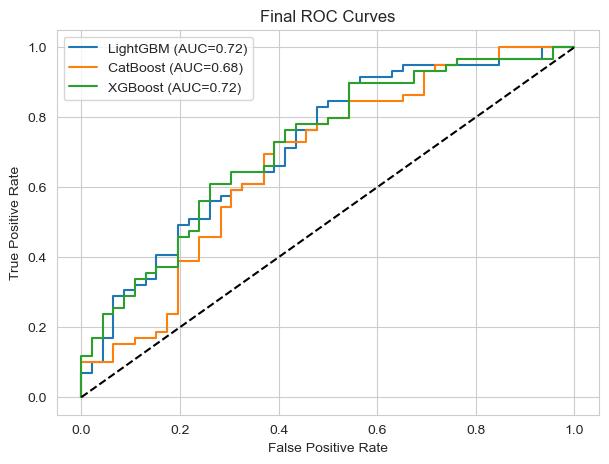

In [104]:
plt.figure(figsize=(7,5))
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")
    print(f"\n{name} Test ROC-AUC: {auc_score:.3f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curves")
plt.legend()
plt.show()

## 8. Save Best XGBoost Model

In [105]:
joblib.dump(best_xgb, 'xgb_model.pkl')

['xgb_model.pkl']